# PG-means for Location Consensus

In this notebook, I compare my method of finding the location consensus (henceforth "PG-means consensus") to Radio Galaxy Zoo's method of finding location consensus (henceforth "KDE consensus"). In particular, I'm interested in

- speed difference between the methods
- robustness difference between the methods
- agreement between the methods

I also want to get some diagrams and plots I can use for a write-up, so I'll be trying to distill these points into diagrams and plots.

## Setup

In [1]:
import collections
import functools
import operator
import sys

import matplotlib.pyplot
import numpy

matplotlib.pyplot.set_cmap('hot')

sys.path.insert(1, '..')
import crowdastro.config
import crowdastro.data
import crowdastro.labels
import crowdastro.rgz_analysis.consensus
import crowdastro.show

%matplotlib inline

Note that there are two sections to a consensus. These are the radio component consensus, and the location consensus. I only want to test the latter, so the radio component consensus code should be the same. However, KDE consensus is interwoven with a method of finding the radio component consensus, so I will have to use that method and adapt my code to work with it.

In [24]:
def get_subject_consensus(subject, significance=0.02):
    """Finds the volunteer consensus for radio combination and source location.
    
    This is adapted from crowdastro.labels.get_subject_consensus, using Kyle Willett's
    radio consensus method instead of my own.

    subject: RGZ subject dict.
    significance: Optional. Significance level for splitting consensus coords.
    -> dict mapping radio signatures to ((x, y) NumPy arrays, or None).
    """

    classifications = crowdastro.data.get_subject_classifications(subject)
    if not classifications:
        return {}
    
    ## Kyle's code begins here.
    cdict = {}
    unique_users = set()
    clist_all = []
    listcount = []
    clen_start = 0
    for c in classifications:
        clist_all.append(c)
        clen_start += 1
        try:
            user_name = c['user_name']
        except KeyError:
            user_name = 'Anonymous'
        
        if user_name not in unique_users or user_name is 'Anonymous':
            unique_users.add(user_name)
            listcount.append(True)
            
            # List of checksums over all possible combinations.
            sumlist = []
            
            # Skip metadata.
            goodann = [x for x in c['annotations']
                       if (list(x.keys())[0] not in {
                            'finished_at', 'started_at', 'user_agent', 'lang', 'pending'})]
            n_galaxies = len(goodann)
            
            if n_galaxies:
                for idx, ann in enumerate(goodann):
                    xmaxlist = []
                    try:
                        radio_comps = ann['radio']
                        
                        # Loop over radio components.
                        if radio_comps != 'No Contours':
                            for rc in radio_comps:
                                xmaxlist.append(float(radio_comps[rc]['xmax']))
                        else:
                            # No contours.
                            xmaxlist.append(-99)
                    except KeyError:
                        xmaxlist.append(-99)
                    
                    # Unique ID.
                    product = functools.reduce(operator.mul, xmaxlist, 1)
                    sumlist.append(round(product, 3))
                
                checksum = sum(sumlist)
            else:
                checksum = -99
            
            c['checksum'] = checksum
            
            # Insert checksum into dictionary with number of galaxies as index.
            if n_galaxies in cdict:
                cdict[n_galaxies].append(checksum)
            else:
                cdict[n_galaxies] = [checksum]
            
        else:
            listcount.append(False)
    
    # Remove duplicates and no object classifications.
    clist = [
        c for lc, c in zip(
            listcount,
            clist_all)
        if lc and c['checksum'] != -99
    ]
    
    clen_diff = clen_start - len(clist)
    
    maxval = 0
    mc_checksum = 0
    
    # Find the radio consensus.
    
    for k, v in cdict.items():
        mc = collections.Counter(v).most_common()
        # Check if most common selection was for no radio.
        if mc[0][0] == -99.0:
            if len(mc) > 1:
                # Yes, take selection with next-highest.
                mc_best = mc[1]
            else:
                continue
        else:
            mc_best = mc[0]
        
        # If the new selection has more counts, choose it as the best match.
        if mc_best[1] > maxval:
            maxval = mc_best[1]
            mc_checksum = mc_best[0]
        
    # Find a galaxy that matches the checksum.
    try:
        cmatch = next(i for i in clist if i['checksum'] == mc_checksum)
    except StopIteration:
        return {}
    
    # Find the annotations for the checksummed galaxies.
    goodann = [x for x in cmatch['annotations']
               if list(x.keys())[0] not in {
                    'finished_at', 'started_at', 'user_agent', 'lang', 'pending'}]
    
    ## End Kyle's code.
    
    # Now, I need to tie together Kyle's interface with mine.
    # I expect a dict mapping radio IDs to a list of (x, y) locations.
    
    radio_consensus_classifications = collections.defaultdict(list)

    for c in clist:
        if c['checksum'] == mc_checksum:
            for a in c['annotations']:
                if 'radio' not in a:
                    continue
                # Get product of xmaxes to use as radio ID.
                rid = functools.reduce(operator.mul,
                        [float(r['xmax']) for r in a['radio'].values()], 1)
                radio_consensus_classifications[rid].append(
                    (float(a['ir']['0']['x']), float(a['ir']['0']['y']))
                )
    
    consensus = {}  # Maps radio signatures to (x, y) NumPy arrays.
    gmms = {}  # Maps radio signatures to GMMs.
    c_points = {}  # Maps radio signatures to clicks.
    for radio_signature in radio_consensus_classifications:
        n_no_source = 0  # Number of people who think there is no source.
        xs = []
        ys = []
        for c in radio_consensus_classifications[radio_signature]:
            if c[0] is None or c[1] is None:
                # No source.
                n_no_source += 1
                continue
            
            # Normally we convert to FITS coordinates, but we should use the same
            # coordinates as Kyle's code. These are scaled by 500 / 424.
            x = c[0] * 500 / 424  # * crowdastro.config.get('click_to_fits_x')
            y = c[1] * 500 / 424  # * crowdastro.config.get('click_to_fits_y')
            xs.append(x)
            ys.append(y)

        if (n_no_source >
                len(radio_consensus_classifications[radio_signature]) // 2):
            # Majority think that there is no source.
            # Note that if half of people think there is no source and half
            # think that there is a source, we'll assume there is a source.
            consensus[radio_signature] = numpy.array([None, None])
            continue

        # Find the consensus source.
        points = numpy.vstack([xs, ys])
        c_points[radio_signature] = points
        gmm = crowdastro.labels.pg_means(points.T, significance=significance, projections=24)

        if gmm is None:
            # In case of no agreement, assume we have no source.
            logging.warning('No consensus for %s but non-zero classifications.',
                            subject['zooniverse_id'])
            consensus[radio_signature] = numpy.array([None, None])
        else:
            consensus[radio_signature] = gmm.means_[gmm.weights_.argmax()]
        
        gmms[radio_signature] = gmm

    return consensus, gmms, c_points

In [25]:
subject = crowdastro.data.db.radio_subjects.find_one(
        {'metadata.survey': 'atlas', 'state': 'complete'})
# crowdastro.show.subject(subject)

In [26]:
get_subject_consensus(subject)

({122.85618152302268: array([ 249.94449096,  241.13172855]),
  198.21655859377296: array([ 466.79459578,   59.60657012])},
 {122.85618152302268: GMM(covariance_type='full', init_params='wmc', min_covar=0.001,
    n_components=1, n_init=1, n_iter=100, params='wmc', random_state=None,
    thresh=None, tol=0.001, verbose=0),
  198.21655859377296: GMM(covariance_type='full', init_params='wmc', min_covar=0.001,
    n_components=1, n_init=1, n_iter=100, params='wmc', random_state=None,
    thresh=None, tol=0.001, verbose=0)},
 {122.85618152302268: array([[ 254.05772227,  267.98349057,  250.58962264,  249.05661817,
           250.94338183,  251.76886792,  250.58962264,  248.23113208,
           226.27996049],
         [ 249.59871904,  253.53773585,  251.17924528,  249.76415454,
           248.13286763,  248.82075472,  250.        ,  238.20754717,
           180.94453272]]),
  198.21655859377296: array([[ 474.5765902 ,  463.73820755,  467.57075472,  473.11322194,
           472.64149504,  472.

In [5]:
crowdastro.rgz_analysis.consensus.consensus(subject['zooniverse_id'])

{'answer': {122.856: {'bbox': [('122.85618152302268',
     '148.59797461973457',
     '80.9806809782321',
     '50.36754313888382')],
   'ind': 0,
   'ir_peak': (251.0, 249.0),
   'ir_x': [254.05772227161336,
    267.98349056603774,
    250.58962264150944,
    249.05661816866893,
    250.9433818313311,
    251.7688679245283,
    250.58962264150944,
    248.23113207547172,
    226.2799604883734],
   'ir_y': [249.5987190390533,
    253.53773584905662,
    251.17924528301887,
    249.76415454216723,
    248.13286763317183,
    248.82075471698116,
    250.00000000000003,
    238.20754716981133,
    180.94453271829857],
   'peak_data': {'X': array([[   1.,    1.,    1., ...,    1.,    1.,    1.],
           [   2.,    2.,    2., ...,    2.,    2.,    2.],
           [   3.,    3.,    3., ...,    3.,    3.,    3.],
           ..., 
           [ 497.,  497.,  497., ...,  497.,  497.,  497.],
           [ 498.,  498.,  498., ...,  498.,  498.,  498.],
           [ 499.,  499.,  499., ...,  499

## Robustness

I know that KDE consensus sometimes finds a very large number of potential locations when there are not that many potential locations in the data. This is one of the motivating reasons for implementing PG-means consensus. I'll have a look at one of these cases and see how PG-means consensus handles it.

In [6]:
max_peaks = 0
max_subject = None
for subject in crowdastro.data.get_all_subjects(atlas=True).limit(200):
    consensus = crowdastro.rgz_analysis.consensus.consensus(subject['zooniverse_id'])
    for answer in consensus['answer'].values():
        if 'peak_data' in answer:
            n_peaks = answer['peak_data']['npeaks']
            if n_peaks > max_peaks:
                max_peaks = n_peaks
                max_subject = subject

49


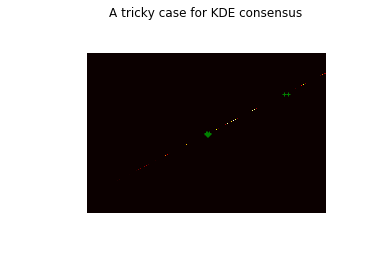

In [21]:
print(max_peaks)
consensus = crowdastro.rgz_analysis.consensus.consensus(max_subject['zooniverse_id'])
cxs, cys = [], []
for c in crowdastro.data.get_subject_classifications(max_subject):
    for annotation in c['annotations']:
        if 'ir' in annotation and annotation['ir'] != 'No Sources':
            cxs.append(float(annotation['ir']['0']['x']) * 500 / 424)
            cys.append(float(annotation['ir']['0']['y']) * 500 / 424)
for answer in consensus['answer'].values():
    if 'peak_data' in answer:
        matplotlib.pyplot.pcolormesh(answer['peak_data']['X'],
                                     answer['peak_data']['Y'],
                                     answer['peak_data']['Z'])
        matplotlib.pyplot.axis('off')
        matplotlib.pyplot.scatter(cxs, cys, marker='+', c='green')
        matplotlib.pyplot.title('A tricky case for KDE consensus')
        matplotlib.pyplot.show()

Let's compare this to PG-means consensus.

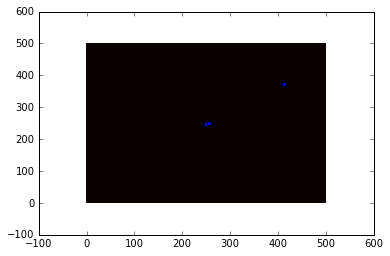

In [41]:
consensus_locs, consensus_gmms, consensus_points = get_subject_consensus(max_subject)
for loc, gmm, points in zip(consensus_locs.values(), consensus_gmms.values(), consensus_points.values()):
    xs, ys = numpy.meshgrid(numpy.linspace(0, 500, 100), numpy.linspace(0, 500, 100))
    for weight, mean, covar in zip(gmm.weights_, gmm.means_, gmm.covars_):
        zs = weight * numpy.exp(-(covar[0, 0] * (xs - mean[0])**2/
                                - 2 * covar[0, 1] * (xs - mean[0]) * (ys - mean[1])
                                + covar[1, 1] * (ys - mean[1])**2))
    
        matplotlib.pyplot.pcolormesh(xs, ys, zs)
        matplotlib.pyplot.scatter(points[0, :], points[1, :])
        matplotlib.pyplot.show()

Interestingly, this looks to be a hard problem for PG-means too!

## Agreement

In this section, I will run PG-means consensus and KDE consensus over 200 random ATLAS subjects and compare the locations found, as well as the number of potential locations found.
